Many modern adversarial domain adaptation methods assume
> predictions must be made based on features that cannot discriminate between the training (source) and test (target) domains.

[source](http://jmlr.csail.mit.edu/papers/volume17/15-239/15-239.pdf)

I was curious whether our method of generating confounding shift results in dataset where we can distinguish between training and testing examples.

For the Twitter gender/location data, the answer is no. This suggests that the adversarial domain adaptation methods would not do very well on our task, though of course we will need to compare empirically.

** The below was run on rampart. **

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from importlib import reload
import adaptive_confound.utils as acu
import adaptive_confound.control as acc
import adaptive_confound.topic_model as actm

/home/culotta/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [30]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pickle
import os.path
import tensorflow as tf
import itertools as it

from datetime import datetime
from tqdm import tqdm
from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from copy import deepcopy
from scipy.stats import mode, pearsonr
from collections import Counter, defaultdict

In [5]:
ystr = 'location'
zstr = 'gender'
twitter = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y={}_z={}.pkl".format(ystr, zstr))
twitter.create_biased_datasets(1000, np.linspace(.1,.9,9), k=1)

In [27]:
product_dataset = it.product(
    twitter.get_biased_datasets(kind='train'),
    twitter.get_biased_datasets(kind='test')
)
iterator = tqdm( list( enumerate( product_dataset ) ) )

bias_diffs = []
accuracies = []
for i, (d_train, d_test) in iterator:
    bias_diff = d_test.get_bias() - d_train.get_bias()
    X = sp.vstack((d_train.X, d_test.X))
    y = np.array([0]*len(d_train.y) + [1]*len(d_test.y))
    clf = LogisticRegression()
    accuracies.append(np.mean(cross_val_score(clf, X, y)))
    bias_diffs.append(bias_diff)
    print(bias_diff, accuracies[-1])


  1%|          | 1/81 [00:04<05:29,  4.11s/it]

0.0002132951280173212 0.496992501484



  2%|▏         | 2/81 [00:07<05:16,  4.01s/it]

0.09961687365684437 0.492012971055


  4%|▎         | 3/81 [00:11<05:11,  3.99s/it]

0.20100852375624795 0.499515983049


  5%|▍         | 4/81 [00:15<05:10,  4.03s/it]

0.300412102285075 0.492029454604


  6%|▌         | 5/81 [00:19<05:02,  3.97s/it]

0.4008097165991903 0.472493451535


  7%|▋         | 6/81 [00:23<04:59,  3.99s/it]

0.5012073309133056 0.504014493535


  9%|▊         | 7/81 [00:27<04:50,  3.92s/it]

0.6006109094421327 0.495501489513


 10%|▉         | 8/81 [00:32<05:01,  4.14s/it]

0.7020025595415362 0.517522013031


 11%|█         | 9/81 [00:36<05:05,  4.24s/it]

0.8014061380703632 0.506003008997


 12%|█▏        | 10/81 [00:41<05:08,  4.35s/it]

-0.10059642147117297 0.504024983067


 14%|█▎        | 11/81 [00:45<04:54,  4.21s/it]

-0.001192842942345923 0.499989510469


 15%|█▍        | 12/81 [00:49<04:50,  4.21s/it]

0.10019880715705765 0.506000011988


 16%|█▌        | 13/81 [00:53<04:41,  4.14s/it]

0.19960238568588468 0.506000011988


 17%|█▋        | 14/81 [00:57<04:34,  4.09s/it]

0.3 0.482987478496


 19%|█▊        | 15/81 [01:01<04:33,  4.14s/it]

0.4003976143141153 0.489499979021


 20%|█▉        | 16/81 [01:06<04:38,  4.29s/it]

0.4998011928429424 0.499481517446


 21%|██        | 17/81 [01:11<04:45,  4.47s/it]

0.6011928429423459 0.511022999047


 22%|██▏       | 18/81 [01:15<04:45,  4.53s/it]

0.7005964214711728 0.512509515504


 23%|██▎       | 19/81 [01:20<04:39,  4.51s/it]

-0.20019156317157782 0.508496520473


 25%|██▍       | 20/81 [01:24<04:35,  4.52s/it]

-0.10078798464275077 0.490006473539


 26%|██▌       | 21/81 [01:28<04:23,  4.39s/it]

0.0006036654566528021 0.500986015956


 27%|██▋       | 22/81 [01:32<04:11,  4.27s/it]

0.10000724398547983 0.500503497509


 28%|██▊       | 23/81 [01:36<04:01,  4.16s/it]

0.20040485829959515 0.485001468534


 30%|██▉       | 24/81 [01:41<03:59,  4.20s/it]

0.30080247261371046 0.507038475601


 31%|███       | 25/81 [01:45<03:53,  4.17s/it]

0.40020605114253754 0.487992483501


 32%|███▏      | 26/81 [01:49<03:51,  4.21s/it]

0.501597701241941 0.492493990997


 33%|███▎      | 27/81 [01:54<03:55,  4.35s/it]

0.601001279770768 0.493998489507


 35%|███▍      | 28/81 [01:58<03:52,  4.39s/it]

-0.300596421471173 0.525999052945


 36%|███▌      | 29/81 [02:02<03:47,  4.37s/it]

-0.20119284294234593 0.502995510481


 37%|███▋      | 30/81 [02:07<03:39,  4.30s/it]

-0.09980119284294237 0.497525969083


 38%|███▊      | 31/81 [02:11<03:35,  4.32s/it]

-0.00039761431411533543 0.511507015998


 40%|███▉      | 32/81 [02:15<03:32,  4.35s/it]

0.09999999999999998 0.491485497474


 41%|████      | 33/81 [02:20<03:26,  4.29s/it]

0.2003976143141153 0.509004513496


 42%|████▏     | 34/81 [02:24<03:17,  4.20s/it]

0.2998011928429424 0.508502514491


 43%|████▎     | 35/81 [02:28<03:11,  4.17s/it]

0.4011928429423459 0.500522978068


 44%|████▍     | 36/81 [02:32<03:09,  4.22s/it]

0.5005964214711729 0.488987490484


 46%|████▌     | 37/81 [02:36<03:09,  4.30s/it]

-0.40059642147117297 0.502515989043


 47%|████▋     | 38/81 [02:41<03:08,  4.38s/it]

-0.30119284294234594 0.496511481541


 48%|████▊     | 39/81 [02:46<03:05,  4.42s/it]

-0.19980119284294234 0.512016507525


 49%|████▉     | 40/81 [02:50<03:02,  4.45s/it]

-0.10039761431411531 0.518503533474


 51%|█████     | 41/81 [02:54<02:56,  4.42s/it]

0.0 0.463509917103


 52%|█████▏    | 42/81 [02:59<02:49,  4.34s/it]

0.10039761431411531 0.484003464542


 53%|█████▎    | 43/81 [03:03<02:45,  4.34s/it]

0.1998011928429424 0.488501975029


 54%|█████▍    | 44/81 [03:07<02:38,  4.29s/it]

0.30119284294234594 0.512508016999


 56%|█████▌    | 45/81 [03:12<02:35,  4.33s/it]

0.4005964214711729 0.497495998993


 57%|█████▋    | 46/81 [03:16<02:35,  4.45s/it]

-0.5005964214711729 0.50349900799


 58%|█████▊    | 47/81 [03:21<02:31,  4.45s/it]

-0.4011928429423459 0.505511499523


 59%|█████▉    | 48/81 [03:25<02:30,  4.55s/it]

-0.2998011928429423 0.502997008985


 60%|██████    | 49/81 [03:30<02:25,  4.56s/it]

-0.2003976143141153 0.508028987071


 62%|██████▏   | 50/81 [03:35<02:20,  4.53s/it]

-0.09999999999999998 0.493491994989


 63%|██████▎   | 51/81 [03:39<02:12,  4.43s/it]

0.00039761431411533543 0.524499049948


 64%|██████▍   | 52/81 [03:43<02:06,  4.37s/it]

0.09980119284294242 0.513504522487


 65%|██████▌   | 53/81 [03:47<01:59,  4.28s/it]

0.20119284294234596 0.491025456594


 67%|██████▋   | 54/81 [03:51<01:53,  4.20s/it]

0.30059642147117294 0.503001504499


 68%|██████▊   | 55/81 [03:55<01:51,  4.27s/it]

-0.601001279770768 0.524019528511


 69%|██████▉   | 56/81 [04:00<01:45,  4.23s/it]

-0.501597701241941 0.512524500548


 70%|███████   | 57/81 [04:04<01:40,  4.18s/it]

-0.40020605114253743 0.510504516493


 72%|███████▏  | 58/81 [04:08<01:35,  4.15s/it]

-0.3008024726137104 0.523995552439


 73%|███████▎  | 59/81 [04:12<01:31,  4.15s/it]

-0.2004048582995951 0.495511979045


 74%|███████▍  | 60/81 [04:17<01:30,  4.31s/it]

-0.10000724398547978 0.528510546475


 75%|███████▌  | 61/81 [04:21<01:28,  4.42s/it]

-0.0006036654566526911 0.52049354744


 77%|███████▋  | 62/81 [04:26<01:25,  4.51s/it]

0.10078798464275085 0.528500056943


 78%|███████▊  | 63/81 [04:30<01:20,  4.49s/it]

0.20019156317157782 0.494472016927


 79%|███████▉  | 64/81 [04:35<01:14,  4.38s/it]

-0.7022158546695535 0.524514034993


 80%|████████  | 65/81 [04:39<01:08,  4.27s/it]

-0.6028122761407265 0.511507015998


 81%|████████▏ | 66/81 [04:43<01:03,  4.21s/it]

-0.501420626041323 0.512003020985


 83%|████████▎ | 67/81 [04:47<01:00,  4.29s/it]

-0.4020170475124959 0.493491994989


 84%|████████▍ | 68/81 [04:51<00:56,  4.32s/it]

-0.3016194331983806 0.497007486528


 85%|████████▌ | 69/81 [04:56<00:53,  4.47s/it]

-0.20122181888426527 0.509999520479


 86%|████████▋ | 70/81 [05:01<00:49,  4.50s/it]

-0.10181824035543818 0.509003014991


 88%|████████▊ | 71/81 [05:05<00:45,  4.52s/it]

-0.0004265902560346424 0.500999502497


 89%|████████▉ | 72/81 [05:10<00:40,  4.54s/it]

0.09897698827279233 0.494994994995


 90%|█████████ | 73/81 [05:14<00:35,  4.45s/it]

-0.8014061380703632 0.51799853746


 91%|█████████▏| 74/81 [05:18<00:30,  4.36s/it]

-0.7020025595415362 0.50099051147


 93%|█████████▎| 75/81 [05:23<00:26,  4.35s/it]

-0.6006109094421326 0.505995516475


 94%|█████████▍| 76/81 [05:27<00:22,  4.45s/it]

-0.5012073309133056 0.51198803594


 95%|█████████▌| 77/81 [05:31<00:17,  4.33s/it]

-0.4008097165991903 0.487998477519


 96%|█████████▋| 78/81 [05:35<00:12,  4.21s/it]

-0.300412102285075 0.491005976036


 98%|█████████▊| 79/81 [05:40<00:08,  4.28s/it]

-0.2010085237562479 0.496992501484


 99%|█████████▉| 80/81 [05:44<00:04,  4.22s/it]

-0.09961687365684435 0.49850898803


100%|██████████| 81/81 [05:48<00:00,  4.12s/it]

-0.0002132951280173767 0.491978505452


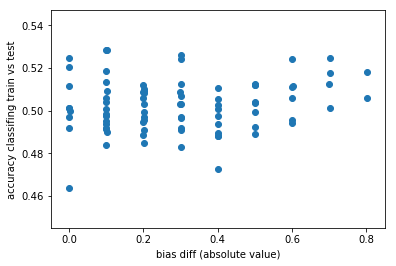

correlation:


(0.15692190736700379, 0.16180391917072098)

In [36]:
# only very weak correlation between bias diff and accuracy of discriminating between training and test set...
plt.figure()
plt.scatter(np.abs(bias_diffs), accuracies)
plt.xlabel('bias diff (absolute value)')
plt.ylabel('accuracy classifing train vs test')
plt.show()
print('correlation:')
pearsonr(np.abs(bias_diffs), accuracies)